# Cell Image Classification

Dieses interactive Jupyter-Notebook erklärt die Architektur von Neuronalen Netze und das Programmieren dieser mithilfe von der Bibliothek PyTorch. Die Aufgabe wird es sein anhand eines medizinischen Datensatzes, welcher aus Bildern von infizierten und gesunden Zellen besteht, ein Neuronales Netz selber zu bauen, welches die Klassifikation dieser Zell-Bilder übernimmt. 
Das Notebook ist in verschiedene Kapitel unterteil: 
1. Importieren der Bibliotheken und Set-Up
2. Laden und Vorverarbeiten der Bild-Daten
3. Bauen eines eigenen Neuronalen Netzes
4. Trainieren des Neuronalen Netzes
5. Evaluieren des Neuronalen Netzes
6. Erklärbarkeit des Modells



### 1. Importieren der Bibliotheken und Set-Up
Die folgenden Bibliotheken werden benötigt um alle Zellen des Notebooks auszuführen. Im Folgenden werden ein paar von Ihnen erklärt, im Bezug darauf, wie sie in diesem Notebook gebraucht werden.
- **`import os`** – Zugriff auf Betriebssystemfunktionen (Dateipfade, Umgebungsvariablen).  
- **`import random`** – Funktionen zum Generieren zufälliger Zahlen und Permutationen.  
- **`import numpy as np`** – Numerische Berechnungen mit Arrays. NumPy Arrays ist eine effiziente und leistungsstarke Datenstruktur, welches die Liste ersetzt. In einem Array haben alles Elemente denselben Datentyp und sie können mehrdimensional sein. Arrays werden hier vor allem als Übergang zu PyTorch Tensoren benutzt. Z.B. werden Daten in Listen zu NumPy Arrays und dann zu PyTorch Tensoren umgewandelt. Dies brauchen wir nicht, jedoch müssen wir PyTorch Tensoren wieder in NumPy Arrays umwandeln, sodass diese dann an andere Bibliotheken weiter gegeben werden können wie z.B. zum Visualizieren. Den die anderen Bibliotheken können nichts mit Tensoren anfangen, aber mit Arrays.
- **`import matplotlib.pyplot as plt`** – Visualisierungs-Bibliothek 
- **`from PIL import Image`** – Bildverarbeitung mit Pillow (PIL). Wird verwendet um Bilder außerhalb von Pytorch zu laden. 
- **`from tqdm import tqdm`** – Fortschrittsbalken für Schleifen. Lässt uns den Fortschritt des Trainings besser darstellen.


##### PyTorch-Imports

- **`import torch`** – PyTorch, die schon beschriebene Deep-Learning-Bibliothek, welche uns ein Framework bietet unsere eigenen Modelle zu bauen ohne z.B. die Backpropagation selber zu implementieren. Viele der folgenden Imports werden später nochmal genauer erläutert.
- **`import torch.nn as nn`** – Enthält Module für neuronale Netze. Der große Unterschied zwischen Modulen (nn) und den folgenden Funktionen (F) ist, dass Module erst initalisiert werden müssen. Möchte ich z.B. einen Loss berechnen, so habe ich zwei Möglichkeiten:
```python
#1. Möglichkeit als Modul
#Initalisieren der Loss-Funktion bzw. des Moduls
loss_Funktion = nn.L1Loss()
#Berechnen des Loss bzw. Anwenden des Moduls
loss = loss_Funktion(output, target)

#2. Möglichkeit direkt als Funktion
loss = F.l1loss(output, target)
``` 
- **`import torch.nn.functional as F`** – Funktionen für neuronale Netze (Aktivierungen, Verluste). Funktionen haben meist den gleichen Namen wie Module werden aber ganz in Kleinbuchstaben geschrieben.
- **`import torch.optim as optim`** – Optimierungsalgorithmen für neuronale Netze.  
- **`from torchvision import datasets, transforms`** – Bilddatensätze und Transformationen aus `torchvision`.  
- **`from torch.utils.data import DataLoader, random_split`** – Datenlade- und Aufteilungshilfen für PyTorch.  
- **`import torchvision.models as models`** – Vorgefertigte neuronale Netzmodelle aus `torchvision`.  

In [1]:
import os
import random
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
from tqdm import tqdm
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, random_split


import torchvision.models as models

# Diese Zeile fragt ab, ob Nvidia GPU(s) und die Schnittstelle Cuda für diese verfügbar ist. 
# Da das Verwenden von GPUs das Training und generell das Benutzen des Modells beschleunigt, wollen wir diese falls vorhanden nutzen.
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cpu


In [2]:
# Seed everything
seed = 100
random.seed(seed)
np.random.seed(seed)
torch.manual_seed(seed)
if torch.cuda.is_available():
    torch.cuda.manual_seed(seed)

### Preprocessing
In diesem Schritt laden wir unsere Daten und verarbeiten sie dabei gleich vor. 
Der Datensatz, den wir verwenden ist von der bekannten Machine-Learning-Plattform Kaggle. Er ist also schon im richtigen Format, welches so aussieht:

```bash
Cell_image_dataset/
    train/
        class_0/
        class_1/
        ...
    test/
        class_0/
        class_1/
        ...
```
wobei jeder unterordner (`class_0`, `class_1`, etc.) Bilder zu dieser gegebenen Klasse enthält.
Wir haben bei unserem Datensatz nur die 2 Klassen: `parasitized`, `uninfected`. 
Dabei ist die Reihenfolge auch wichtig, Klasse 0 ist also `parasitized` und Klasse 1 `uninfected` und nicht anders herum.

Die genaue Struktur unseres Datensatzes sieht also so aus:
```bash
Cell_image_dataset/
    train/
        parasitized/
            image0.png
            image1.png
            image2.png
            ...
        uninfected/
            image0.png
            image1.png
            image2.png
            ...
    test/
        parasitized/
            image0.png
            image1.png
            image2.png
            ...
        uninfected/
            image0.png
            image1.png
            image2.png
            ...
```

In [3]:
# Diese beiden Pfade zeigen zu dem Trainings-Ordner und dem Test-Ordner
train_dir = "../../data/Cell_image_dataset/train"
test_dir = "../../data/Cell_image_dataset/test"

# Funktionen, welche die Bild-Daten transformieren. 
# Diese Funktionen werden auf alle Daten angewendet. 
transform = transforms.Compose([
    # Ändert die Größe des Bildes von seiner original-Größe auf die hier angegebene Größe, also 32x32
    # So haben alle Bilder die gleiche Größe von 32x32
    transforms.Resize((32, 32)),
    # Schneidet aus der Mitte des Bildes ein 32x32 Rechteck aus. 
    transforms.CenterCrop((32, 32)),
    # Gibt die Bilder als Tensoren weiter
    transforms.ToTensor(),
])


#Hilfsfunktion
def rgb2gray(rgb):
    """
    Konvertiert ein RGB-Bild von der Form (3, H, W) in ein Graustufenbild (H, W).

    Die Umwandlung erfolgt mit der Standardluminositätsformel:
        Grauwert = 0.2989 * R + 0.5870 * G + 0.1140 * B

    Parameter:
    ----------
    rgb : np.ndarray oder torch.Tensor
        RGB-Bild als NumPy-Array mit der Form (3, H, W).

    Rückgabe:
    ---------
    np.ndarray
        Graustufenbild mit der Form (H, W).
    """
    # Vertauscht die Dimensionen von (3, H, W) zu (H, W, 3)
    rgb = rgb.transpose(1, 2, 0)
    
    # Wendet die Umwandlung zu Graustufen an
    gray = np.dot(rgb[..., :3], [0.2989, 0.5870, 0.1140])
    
    return gray

def label_encoding(target):
    """
    Wandelt eine binäre Zielvariable in eine One-Hot-Encoding-Darstellung um.

    Parameter:
    ----------
    target : int oder torch.Tensor
        Der Wert der Zielvariable (0 oder 1), entweder als Integer oder als PyTorch-Tensor.

    Rückgabe:
    ---------
    torch.Tensor
        Ein One-Hot-Encoded Tensor der Form (2,).

    Beispiel:
    ---------
    >>> label_encoding(0)
    tensor([1., 0.])

    >>> label_encoding(1)
    tensor([0., 1.])
    """

    # Erzeugt einen Tensor mit zwei Nullen
    one_hot = torch.zeros(2)

    # Setzt an der Indexposition `target` eine 1
    one_hot[target] = 1

    return one_hot

def label_decoding(target):
    """
    Wandelt eine One-Hot-Encoded-Darstellung zurück in die ursprüngliche Klasse um.

    Parameter:
    ----------
    target : torch.Tensor oder np.ndarray
        Ein One-Hot-Encoded-Vektor mit der Form (N,), wobei N die Anzahl der Klassen ist. Hier N=2.

    Rückgabe:
    ---------
    int oder str
        Die dekodierte Klasse basierend auf dem Mapping `IDX_CLASS`.

    Beispiel:
    ---------
    >>> label_decoding(torch.tensor([0, 1]))
    'uninfected'  # Hier: IDX_CLASS = {0: 'parasitized', 1: 'uninfected'}
    """
    return IDX_CLASS[torch.argmax(target).item()]

# Diese Klasse lädt die Bilder als PyTorch Datensatz
trainset = datasets.ImageFolder(
    root=train_dir,
    transform=transform,
    target_transform=(label_encoding),
)

testset = datasets.ImageFolder(
    root=test_dir,
    transform=transform,
    target_transform=(label_encoding),
)

CLASS_IDX = trainset.class_to_idx.copy()
print(f"CLASS_IDX: {CLASS_IDX}")
IDX_CLASS = {v: k for k, v in CLASS_IDX.items()}
print(f"IDX_CLASS: {IDX_CLASS}")

CLASS_IDX: {'parasitized': 0, 'uninfected': 1}
IDX_CLASS: {0: 'parasitized', 1: 'uninfected'}


Diagramm zum Erklären des Ablaufs

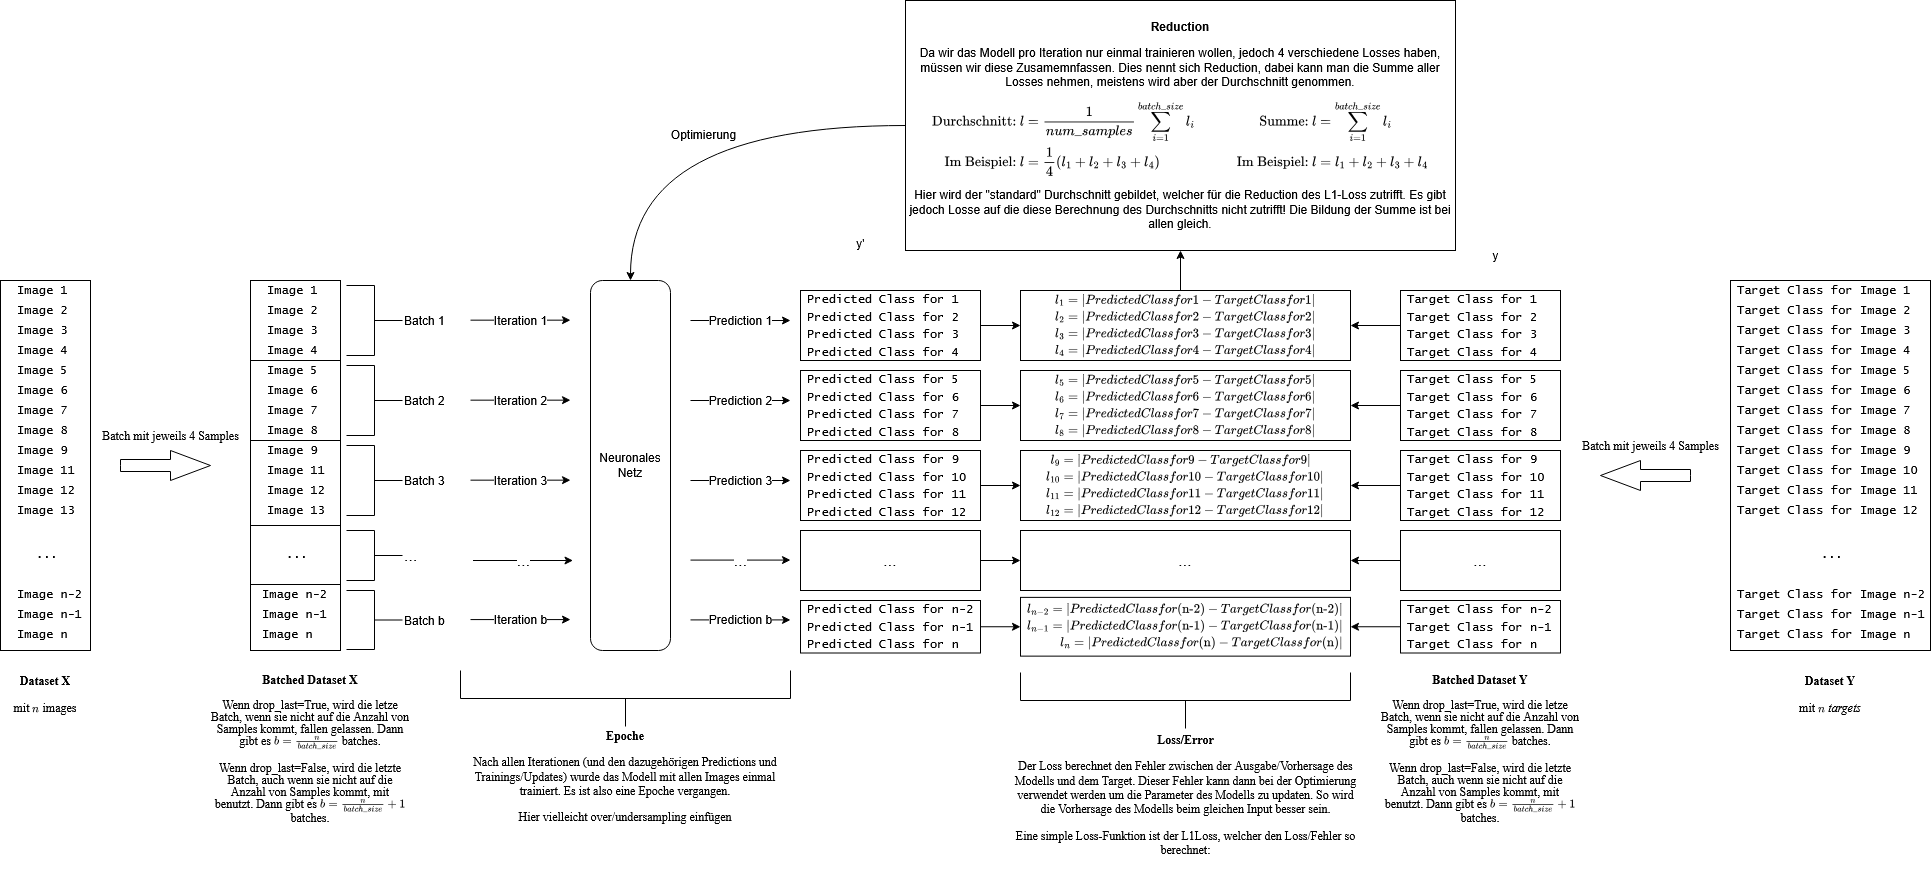

Erklärung der wichtigsten Parameter:
| Parameter       | Beschreibung |
|---------------|-------------|
| `batch_size` | Die Anzahl der Samples (Images) pro Batch. |
| `shuffle`  | Mischt die Daten für jedes Training zufällig. Dies ist aus folgenden Umständen wichtig: <ul><li> **Learning Bias**<br>Zum Beispiel kann es vorkommen, dass das Modell erst nur Bilder von infizierten Zellen bekommt und danach nur Bilder von uninfizierten Zellen. So würde das Modell zuerst die Bilder von infizierten Zellen erlernen, kann dann aber schlecht die Bilder für uninfizierte Zellen lernen.</li><li> **Overfitting to Sequence Patterns**<br>Zudem könnte es vorkommen, dass das Modell die Eingabereihenfolge der Bilder erlernt.</li><li>**Hilft bei der Optimierung**<br>Das Shufflen versichert, dass jede Batch verschiedene Datenpunkte hat, was beim Training des Modells hilft bzw. die Konvergenz des Modells erleichtert.</li><li>**Randomness**<br>Shuffeln verursacht Randomness, was dem Modell dabei hilft verschiedene Optimierungs-Pfade zu erkunden.</li></ul> Es macht keinen Sinn Validation-Datensatz oder Test-Datensatz zu shufflen, da wir an diesen Datensätzen nur die Fehler messen. |
| `drop_last` | Ob der letzte unvollständige Batch verworfen wird. |
| `num_workers`   | Anzahl der parallelen Threads für das Laden der Daten. Dies beschleunigt vor allem GPU Training. |
|`pin_memory`| Beschleunigt die Datenübertragung von der CPU zur GPU. Es ist also nur wichtig, wenn sich das Modell auf der GPU befindet.|

Erklärung von Trainings-Datensatz, Validation-Datensatz und Test-Datensatz

#### Trainingsdatensatz
Der Trainingsdatensatz enthält die Daten mit welchen das Modell trainiert. Es lernt also die Zusammenhänge und Muster aus den Daten des Trainingsdatensatzes.

#### Validation-Datensatz
Der Validation-Datensatz wird während des Trainings verwendet. Nach jeder (oder einer bestimmten Anzahl) Epoche(n) wird/werden die Fehler des Modells auf den Validation-Datensatz berechnet. So kann das Modell auch während des Trainings bewertet werden und es kann geguckt werden, wie gut das Modell generalisieren kann: Overfitting/Underfitting. Zudem hilft der Validierungsdatensatz auch noch bei der Hyperparameter-Optimierung. So kann man auch gut sehen, wie viel das Modell pro Epoche lernt.

#### Test-Datensatz
Nachdem das Modell fertig trainiert wurde, wird der Fehler auf den Trainings-Datensatz berechnet. So kann die entgültige Modellleistung erfasst werden, welche dann auch dazu genutzt werden kann um verschiedene Modelle zu vergleichen. Zudem kann dieser Datensatz auch dazu genutzt werden, um zu gucken, wie gut das Modell generalisieren kann. 

Die Aufteilung des Datensatzes variiert je nach Anwendung. Eine häufige Faustregel:

| Datensatz          | Typische Aufteilung |
|--------------------|--------------------|
| **Trainingssatz**  | 70–80% der Daten   |
| **Validierungssatz** | 10–15% der Daten |
| **Testsatz**       | 10–15% der Daten   |

Unser Trainingsdatensatz ist schon gegeben. Deshalb teilen wir nur den Trainingsdatensatz im Verhältnis 80/20 in Trainingsdatensatz und Validation-Datensatz auf.

#### Hyperparameter
Unser Modell trainiert seine Parameter (eher Gewichte genannt) und lernt dadurch die gegebene Aufgabe zu bewältigen. Es gibt aber auch Parameter, die das Modell nicht lernt, sogenannte Hyperparameter. Diese sind die Lernrate, die Größe des Modells (also z.B. wie viele Schichten/Layer das Modell hat), Wahl des Optimierungsalgorithmus, Loss-Funktion etc.. Also Parameter die den Lernalgorithmus des Modells beeinflussen und somit vor dem Lernen/Trainieren festgelegt/verändert werden müssen.

In [4]:
batch_size=100
drop_last = False
# Wird automatisch auf Falsch gesetzt, wenn keine GPU verwendet wird
pin_memory = True if torch.cuda.is_available() else False
# Wird automatisch auf 0 gesetzt, wenn keine GPU verwendet wird. 
# Die num_workers auf höher als 0 zu setzen, wenn auf der CPU trainiert wird kann zu Fehlern oder starken Verlangsamungen bei der Ausführung führen.
num_workers = 5 if torch.cuda.is_available() else 0
# Wir teilen den Trainingsdatensatz im Verhältnis 80/20 in Trainingsdatensatz und Validations-Datensatz auf.
train_size = int(0.8 * len(trainset))
val_size = len(trainset) - train_size
test_size = len(testset)

#teilt den Trainingsdatensatz zufällig in Trainingsdatensatz und Validierungsdatensatz auf
trainset, valset = random_split(trainset, [train_size, val_size])

# Der DataLoader ist die Klasse in PyTorch, welche das Dataset nimmt und für uns ins Batches aufteilt, shuffled, die Memory managed 
# und die letzte Batch droppt, falls gewünscht.
# TrainLoader
trainloader = DataLoader(
    dataset=trainset,
    batch_size=batch_size,
    shuffle=True,
    num_workers=num_workers,
    drop_last=drop_last,
    pin_memory=pin_memory,
)
# ValLoader
valloader = DataLoader(
    dataset=valset,
    batch_size=batch_size,
    shuffle=False,
    num_workers=num_workers,
    drop_last=drop_last,
    pin_memory=pin_memory,
)
# TestLoader
testloader = DataLoader(
    dataset=testset,
    batch_size=batch_size,
    shuffle=False,
    num_workers=num_workers,
    drop_last=drop_last,
    pin_memory=pin_memory,
)
print(f"Size of the Training-Dataset: {train_size} \nSize of the Validation-Dataset: {val_size} \nSize of the Testing-Dataset: {test_size} \n\nNumber of Batches in the Training-DataLoader: {trainloader.__len__()} \nNumber of Batches in the Validation-DataLoader: {valloader.__len__()} \nNumber of Batches in the Testing-DataLoader: {testloader.__len__()}")

Size of the Training-Dataset: 19966 
Size of the Validation-Dataset: 4992 
Size of the Testing-Dataset: 2600 

Number of Batches in the Training-DataLoader: 200 
Number of Batches in the Validation-DataLoader: 50 
Number of Batches in the Testing-DataLoader: 26


#### Input ins Modell

Als letztes wollen wir den Input in das Modell genauer betrachten. 
Wir als Menschen sehen ein Farbbild. Das ist aber nicht das, was das Modell "sieht", dabei ist der Input für Mensch und Maschine gleich. Das Farbbild, welches wir Menschen sehen ist die Überlagerung von 3 Graubildern, welche die Farbbereiche Rot Grün Blau repräsentieren. Das Modell kriegt diese 3 Graubilder zwar genauso wie wir, kann sie aber "getrennter" als wir betrachten. Die folgende Darstellung soll dies veranschaulichen. <br>
Dazu nehmen wir uns ein zufälliges Bild aus einer zufälligen Batch unseres TestLoaders.  Wir zeigen die 3 Graubilder getrennt und legen sie dann übereinander, um ein Farbbild zu erzeugen. Dazu wird auch die Target Klasse für das gewählte Bild ausgegeben. Die Begriffe Target und Label werden synonym verwendet.<br>
Es sollte einem dabei auch auffallen, dass das Original ganz rechts viel schärfer aussieht bzw. die Dimensionen des Bildes viel größer sind. Dies liegt an unseren Transformationen, welche wir am Anfang beim Laden der Daten gleich auf diese angewendet haben. Dabei haben wir unsere Daten auf die gleiche Größe transformiert. Dies ist notwendig, da die Größe der Daten, welche wir in unser Modell geben konstant sein müssen. Die Größe kann gerne angepasst werden, sie muss nur über alle Daten konstant sein. Als letztes haben wir die Bilder in einen PyTorch Tensor Datentypen umgewandelt. Das Modell kann nur diese Datentypen verwenden. 

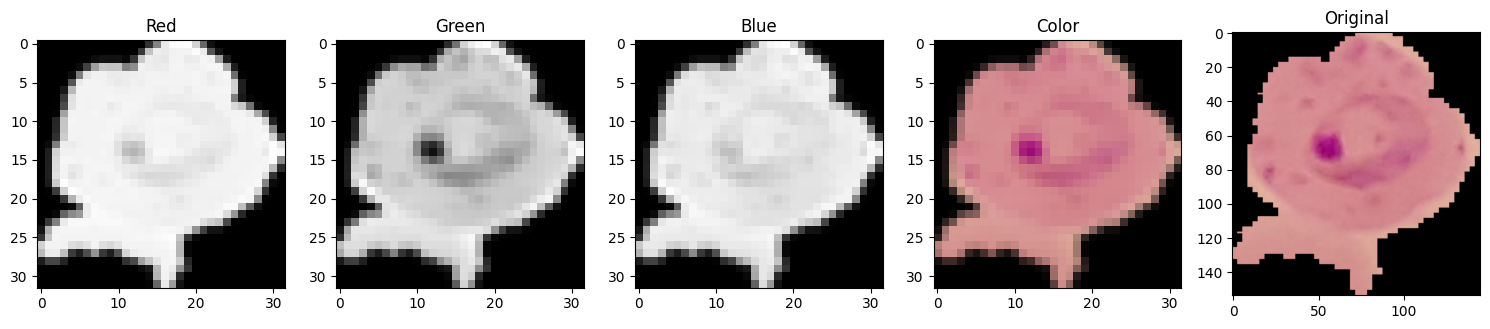

Class: parasitized


In [5]:
pick_random_img=random.randint(0, batch_size-1)
random_batch = next(iter(testloader))
image = random_batch[0][pick_random_img]
label = random_batch[1][pick_random_img]

# Ausgabe des Bildes
fig, axes = plt.subplots(1, 5, figsize=(15, 6))
axes[0].set_title("Red")
axes[0].imshow(image[0, :, :], cmap="gray")
axes[1].set_title("Green")
axes[1].imshow(image[1, :, :], cmap="gray")
axes[2].set_title("Blue")
axes[2].imshow(image[2, :, :], cmap="gray")
axes[3].set_title("Color")
axes[3].imshow(image.transpose(0, 1).transpose(1, 2), cmap="gray")
axes[4].set_title("Original")
axes[4].imshow(Image.open(testset.samples[pick_random_img][0]))
plt.tight_layout()
plt.show()
print(f"Class: {label_decoding(label)}")

#### **Aufgabe 1**

Verändere gerne die transforms.Compose Funktion, führe alle Zellen bis hierhin wieder aus und sehe dir die Unterschiede in der Ausgabe an. Die transforms.Compose sieht bisher so aus:

```Python
transform = transforms.Compose([
    # Ändert die Größe des Bildes von seiner original-Größe auf die hier angegebene Größe, also 32x32
    # So haben alle Bilder die gleiche Größe von 32x32
    transforms.Resize((32, 32)),
    # Schneidet aus der Mitte des Bildes ein 32x32 Rechteck aus. 
    transforms.CenterCrop((32, 32)),
    # Gibt die Bilder als Tensoren weiter
    transforms.ToTensor(),
])
```

Nachdem du dich mit der Funktion und den Transformationen vertraut gemacht hast, verwende bitte erstmal wieder die gegebene transforms.Compose Funktion.


### Modell

Kommen wir nun zum Bauen von unseren Modell. Als erstes lassen sie uns den Aufbau eines Pytorch Modules beschreiben. 
nn.Module ist die Basis Klasse für alle Neuronalen Netzwerke. Die zwei wichtigsten Funktionen dieser Klasse ist die normale init-Funktion und die forward Funktion, welche wie der Name schon sagt, den forward-Pass implementiert. Der Backward pass wird von PyTorch übernommen. Der Grundaufbau unseres Modells sieht also so aus:
```Python
class MyModel(nn.Module):
    def __init__(self, num_classes):
        super(MyModel, self).__init__()
        #Initalisiere deine Module
        pass

    def forward(self, x):
        #gebe den Input an deine vorher Initalisierten Module
        return x
```

In der Init Funktion werden wichtige Parameter und die PyTorch Module initalisiert. 
Diese können dann in der forward-Funktion mit anderen Funktionen aufgerufen werden. Die forward-Funktion wird pro Iteration einmal durchlaufen. 

#### Single Neuron
Um Neuronale Netze verstehen zu können, fangen wir damit an den kleinsten Baustein, ein einzelnes Neuron zu verstehen. 
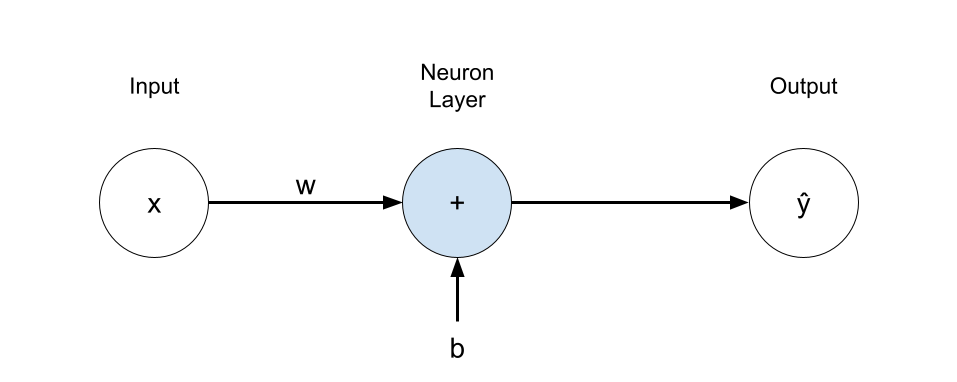 <br>
Der Input x wird mit dem Gewicht w (für weight) multipliziert und mit einem speziellen Gewicht, dem Bias addiert. Das Neuronale Netz lernt, indem es die Gewichte w und b verändert/anpasst. Um den Output zu generieren summiert das Neuron alle Werte, die es bekommt. Es ergibt sich die Funktion:
$$\hat{y}=wx+b$$
Es fällt auf, dass dies die Funktion für eine Linie ist, wobei b der x-Achsen Schnittpunkt ist. Deswegen wird dieses Modell auch Lineare Einheit genannt. Man kann diesen einzelnen Input auch als ein Pixel in unserem Bild betrachten (also ein Pixel von einem der 3 Graubilder). <br>
Ein Neuron kann aber auch mehrere Inputs haben: <br>
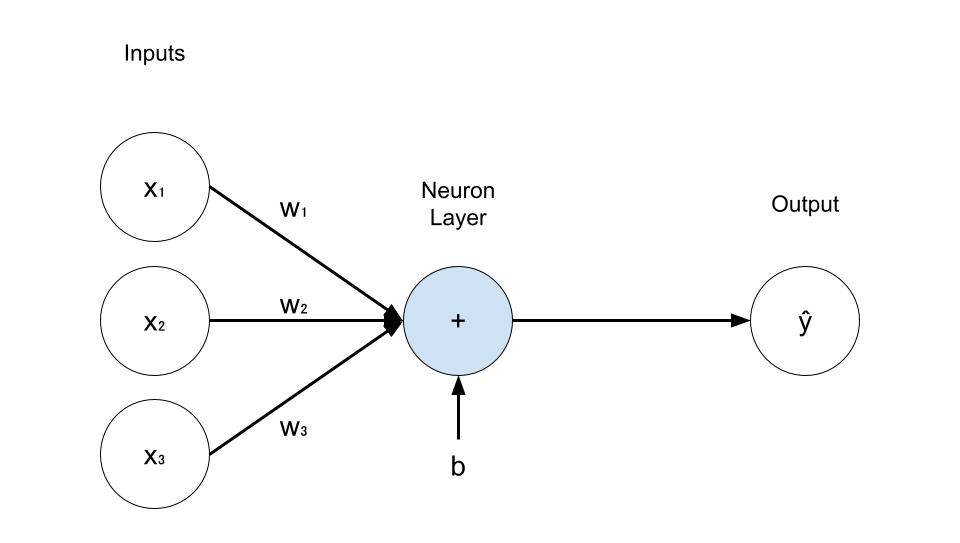 <br>
Als Funktion geschrieben ergibt sich also: 
$$\hat{y}=x_1w_1+x_2w_2+x_3w_3+b$$
Hier als Beispiel also für 3 Inputs/Pixel.
Formal geschrieben:
$$\hat{y}=b+\sum_{i=1}^{m}{x_iw_i}$$
Für $m$ Inputs bzw. $m$ Pixel.

#### Schichten
Neuronale Netzwerke werden in Schichten eingeteilt. Mehrere Lineare Einheiten mit der gleichen Menge von Inputs werden als Lineare Schicht (Linear Layer) bezeichnet. Lineare Schichten bei denen alle Inputs mit jedem Neuron verbunden sind werden als vollständig verbundene Lineare Schicht(fully connnected linear layer) oder auch als dicht (dense) bezeichnet. Spricht man von einer Lineare Schicht wird generell aber angenommen, dass diese dicht bzw. vollständig verbunden ist.<br> 
**Unvollständig** <br>
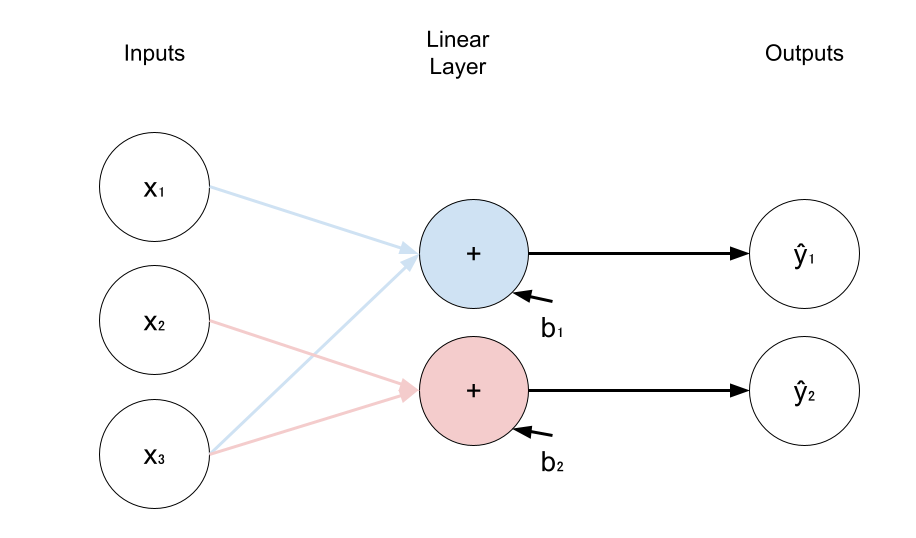 <br>
**Vollständig Verbunden** <br>
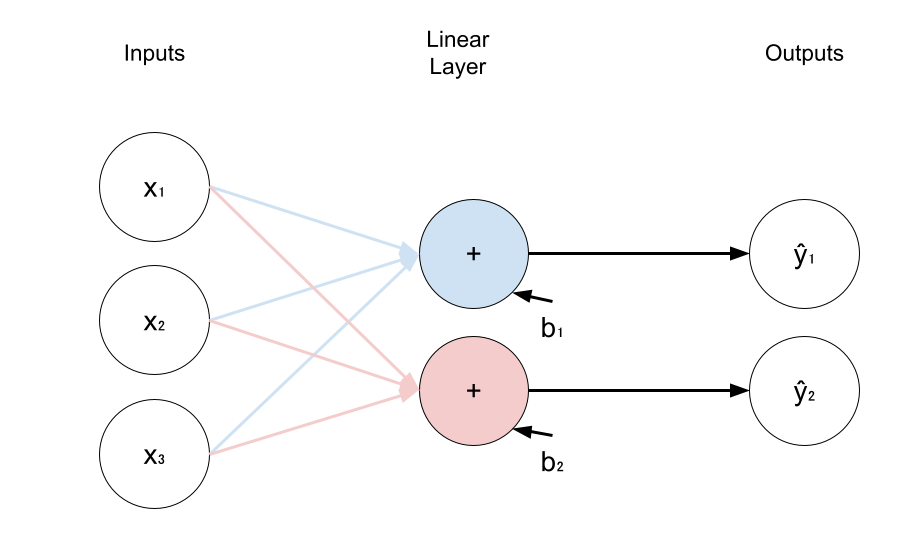 <br>

Formal geschrieben:
$$\hat{y}=Wx+b$$
**Dimensionsbetrachtung** <br>
mit m Inputs und n outputs: <br>
x: (m)<br>
y: (n)<br>

W: (n, m)<br>
b: (n)<br>
$\hat y$: (n)<br>

**PyTorch Implementierung** <br>
```Python
# input-size
m = 20
# output-size
n = 30
# fully-connected linear layer als Modul
fc = nn.Linear(
    # übergebe die input-size
    in_features=m,
    # übergebe die output-size
    out_features=n,
    # Lineare Schichten kann es auch ohne Bias geben
    bias=True,
)
# random input mit dimensionen (batch_size, input_size)
x = torch.randn(128, 20)
# forward pass des Moduls bzw. anwenden der Funktion
y_hat = fc(x)
# output mit dimensionen (batch_size, output_size), also (128, 30)
print(y_hat.shape)
```

#### Die Aktivierungsfunktion
Nehmen wir den Output unseres einzelnen Neuron von oben mit der Funktion $\hat y_1 = w_1x+b_1$ und geben diesen an ein zweites einzelnes Neuron $\hat y_2 = w_2\hat y_1 +b_2$ so erhalten wir: 
$$
\begin{align*}
\hat{y_2} = w_2(w_1x+b_1)+b_2 \\
\hat{y_2} = w_2w_1x + w_2b_1 +b_2 \\
\\
\text{wieder eine lineare Funktion: }\\
\\
\hat{y_2} = w_3x + b_3 \\
\text{mit: }w_3 = w_2w_1 \\
\text{und: }b_3 = w_2b_1 + b_2 \\
\end{align*}
$$
Dies lässt sich auch auf Lineare Schichten übertragen. Zwei Lineare Schichten ohne etwas dazwischen sind also nicht besser als eine Lineare Schicht. Graphisch gesehen können sich Lineare Schichten also nicht aus einer Ebene heraus bewegen. Um dies zu verändern benutzen wir Aktivierungsfunktionen, welche auf den Output einer Linearen Schicht gegeben werden. <br>
Formal geschrieben: 
$$\hat y = f(wx+b)$$
Per Definition ist $f$ bzw. die Aktivierungsfunktion, die Funktion, welche auf den Output einer Neuronales Schicht, also auch einer Linearen Schicht, gegeben wird. <br>
Diese Funktion kann also auch linear sein, wie z.B. die Identitäts-Funktion $y=x$, jedoch hätte man dann das gleiche Problem wie oben dargestellt. Deshalb sind Aktivierungsfunktionen generell nicht-linear, also nicht lineare Aktivierungsfunktionen (non-linear aktivation functions). Wenn man von Aktivierungsfunktionen redet meint man meistens nicht lineare Aktivierungsfunktionen. 

Im Folgenden werden ein paar Aktivierungsfunktionen vorgestellt und die Vorteile bzw. Nachteile erklärt. Diese sind jedoch stark vereinfacht und werden nicht weiter begründet.
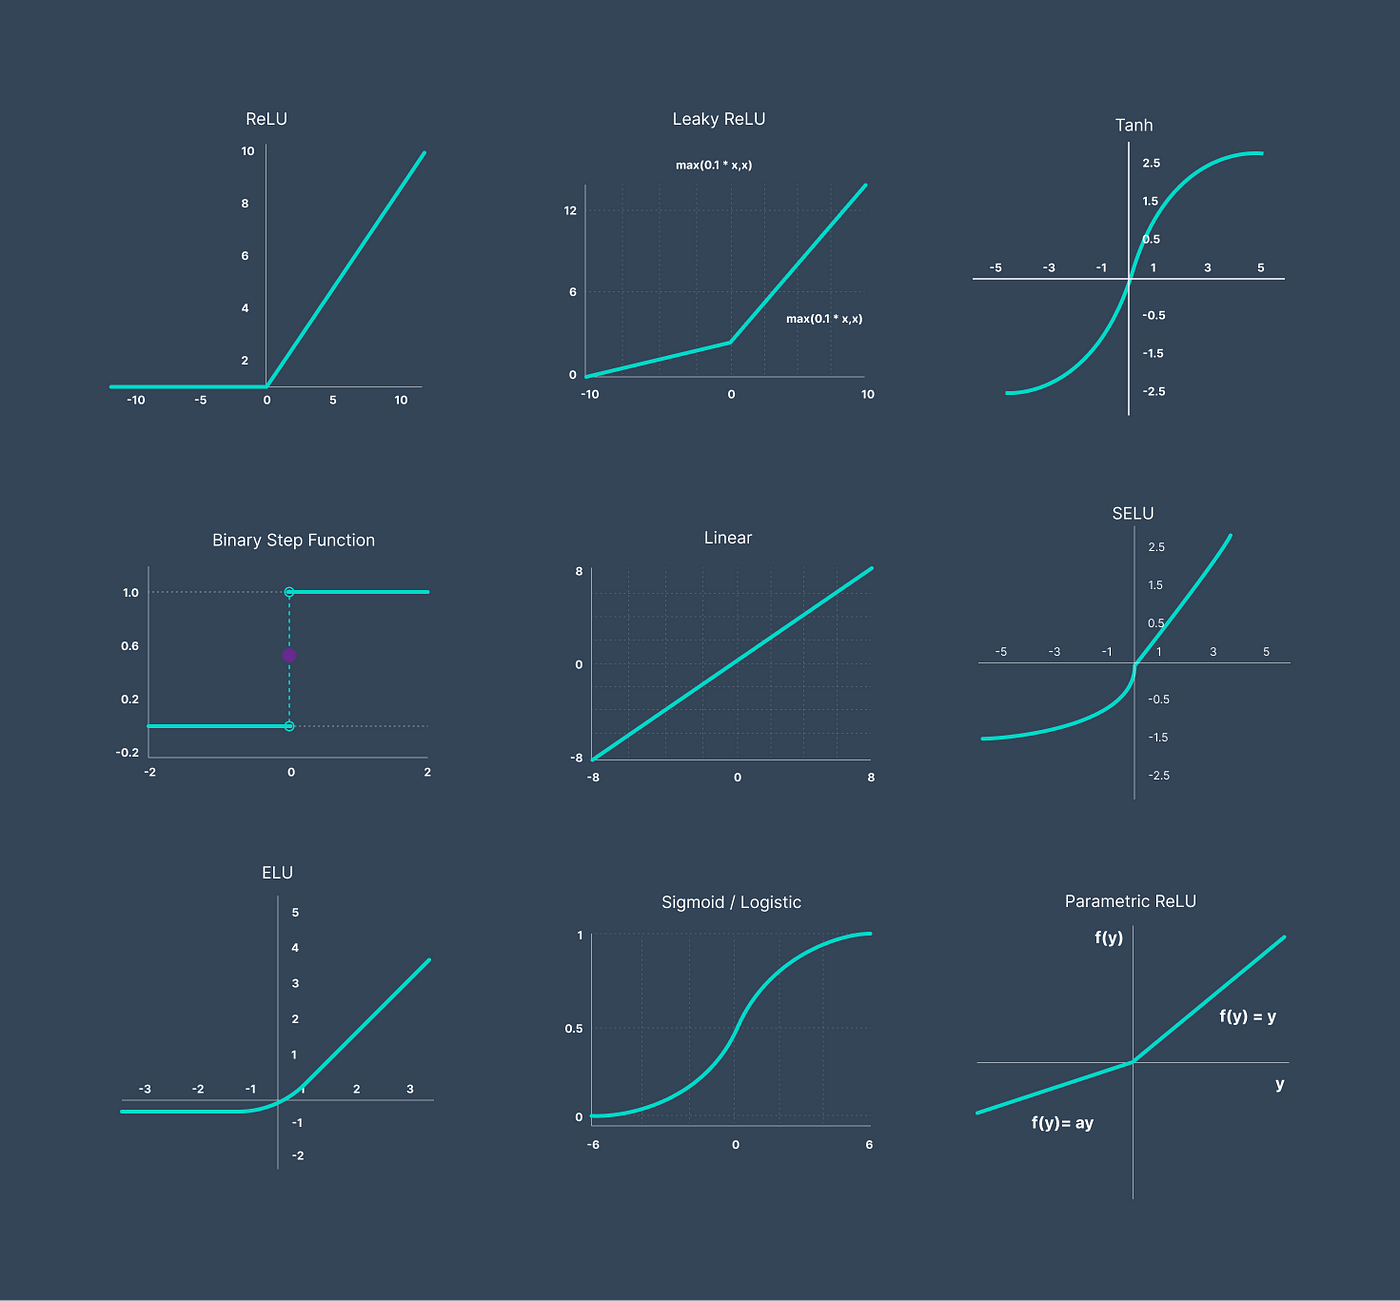


**Rectified Linear Unit (ReLU)** <br>
Alle negativen Inputs werden zu 0, alle positiven Inputs bleiben gleich. 
$$
\text{ReLU}(x) =
\begin{cases}
x & \text{für} \ x \geq 0 \\
0 & \text{für} \ x < 0
\end{cases}
$$
oder auch
$$
\text{ReLU}(x) = \max(0, x)
$$
Vorteile
- Einfach und schnell zu berechnen
- Manchmal kann es bei anderen Aktivierungsfunktionen passieren, dass Gradienten, also die Veränderung auf die Gewichte des Modells zu klein werden. Dies passiert bei der ReLU-Funktion nicht.

Nachteile
- Es kann dazu kommen, dass die Gradienten für manche Neuronen immer 0 sind. Diese Neuronen bleiben dann ausgeschaltet.

Da diese Funktion so einfach zu berechnen ist wird sie sehr oft im Modell verwendet, jedoch kaum als letze Aktivierungsfunktion auf dem Output. Vor allem wird sie im Zusammenhang mit Konvolutionen verwendet.

PyTorch-Implementierung
```Python
# random inputs
x = torch.randn(3, 3)
print(f"Inputs: {x}")
# Implementierung als Modul
relu = nn.ReLU()
y = relu(x)
# Implementierung als Funktion
y = F.relu(x)
print(f"Outputs: {y}")
```

**Sigmoid** <br>
Alle Werte werden zwischen 0 und 1 aufgeteilt. Je kleiner der Input, desto näher an 0 ist der Output. Je größer der Input, desto näher an 1 ist der Output. Gibt die Wahrscheinlichkeit eines Outputs an. 
$$
\sigma(x) = \frac{1}{1 + e^{-x}}
$$
Vorteile
- Da die Sigmoid Funktion die Wahrscheinlichkeit der Klasse 0 anzeigt, wird sie oft für die Ausgabe der Wahrscheinlichkeit bei binären Klassifikationen genommen. Da man hier die Wahrscheinlichkeit für Klasse 1 ganz einfach berechnen kann: $1 - \sigma(x)$

Nachteile
- Für Inputs kleiner als -3 und größer als 3 werden die Gradienten sehr klein, sie verschwinden also praktisch, was dem Training schaden kann. Jedoch kann dies auch ein Vorteil sein, da so Outlier stärker unbeachtet bleiben.
- Zudem ist die Verteilung der Werte zwischen 0 und 1 nicht symmetrisch. Dies schadet dem Training, da es so nur positive Outputs geben kann. Die Veränderungen der Gewichte können also nicht ausbalanciert werden.

Wird eigentlich nur als letze Aktivierungsfunktion auf den Output verwendet, um die Wahrscheinlichkeiten der Klassen zu bekommen.

PyTorch-Implementierung
```Python
# random inputs für eine binäre Klassifikation
x = torch.randn(1)
print(f"Inputs: {x}")
# Implementierung als Modul
sigmoid = nn.Sigmoid()
y = sigmoid(x)
# Implementierung als Funktion
y = F.sigmoid(x)
print(f"Outputs: {y}")
print(f"Wahrscheinlichkeit für Klasse 0: {y.item()}")
print(f"Wahrscheinlichkeit für Klasse 1: {1 - y.item()}")
```

**Tangens hyperbolicus (Tanh)** <br>
Alle Werte werden zwischen -1 und 1 aufgeteilt. Je kleiner der Input, desto näher an -1 ist der Output. Je größer der Input, desto näher an 1 ist der Output.
$$
\tanh(x) = \frac{e^x - e^{-x}}{e^x + e^{-x}}
$$
Vorteile
- Die Verteilung zwischen -1 und 1 macht die Funktion symmetrisch. Diese Verteilung macht es dem Modell einfach von den gegebenen Daten zu lernen.

Nachteile
- Hat das gleiche Problem, dass für Inputs kleiner als -3 und größer als 3 die Gradienten sehr klein werden bzw. verschwinden.

Durch die Verteilung wird die Funktion oft in den inneren Schichten eines Modells verwendet. 

PyTorch-Implementierung
```Python
# random inputs
x = torch.randn(5)
print(f"Inputs: {x}")
# Implementierung als Modul
tanh = nn.Tanh()
y = tanh(x)
# Implementierung als Funktion
y = F.tanh(x)
print(f"Outputs: {y}")
```

**Softmax** <br>
Die Softmax-Funktion kombiniert mehrere Sigmoid Funktionen bzw. "normalisiert" diese. Die Funktion gibt die relative Wahrscheinlichkeit aller Klassen in Abhängigkeit miteinander zurück, sodass diese zu 1 summieren. 
$$
\text{Softmax}(\mathbf{z})_i = \frac{e^{z_i}}{\sum_{j=1}^{n} e^{z_j}} \quad \text{für} \ i = 1, 2, ..., n
$$

Die Softmax-Funktion wird deshalb als letze Funktion auf dem Output für Klassifikationen für mehr als zwei Klassen verwendet (multi-class). 

PyTorch-Implementierung
```Python
# random inputs, hier als Beispiel für 5 Klassen
x = torch.randn(5)
print(f"Inputs: {x}")
# Implementierung als Modul
softmax = nn.Softmax(dim=-1)
y = softmax(x)
# Implementierung als Funktion
y = F.softmax(x, dim=-1)
print(f"Outputs: {y}")
```

#### Konvolutionen (2D)
Eine sehr schnelle und relativ einfache Methode bei der Bildverarbeitung, welche jedoch sehr gute Ergebnisse erzielt, ist die Konvolution(en) (convolutions).
Der Grundbaustein bei Konvolutions-Schichten ist die Konvolution selbst. Dabei fährt eine kleine Gewichts-Matrix, Kernel oder Filter genannt, über den Input multipliziert sich elementweise mit diesem und summiert die sich daraus ergebene Matrix zu einem Wert auf. Dies macht es solange, bis es über den gesammten Input gefahren ist. Die Matrix bzw. der Output der sich daraus ergibt wird Feature-Map genannt. 
Im folgenden Beispiel ist die große hellblaue Matrix der Input bzw. das vermeintliche Bild. Die dunkelblaue Matrix mit welche über den hellblauen Input fährt, mit den kleinen Ziffern ist der Kernel/Filter. Und die grüne Matrix ist die Feature-Map welche sich ergibt, wenn der Kernel über den gesamten Input gefahren ist. <br>
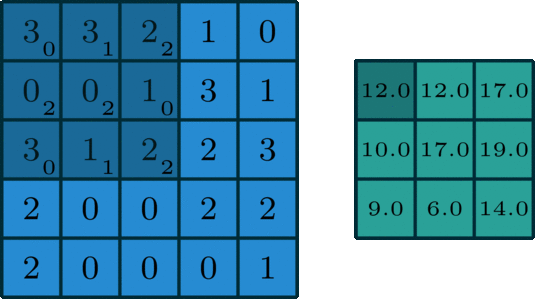 


**Input-Channels, Output-Channels und Bias** <br>
Wie man in dem Beispiel sehen konnte, gibt es nur ein Bild als Input. Wir errinern uns aber, dass wir 3 Bilder als Input haben (Rot Grün Blau). Unser Farbbild hat also die Dimensionen (3, h, w), man sagt auch, dass die input channels 3 sind. Um diese Bilder trotzdem zu verarbeiten fährt der selbe Kernel/Filter über alle 3 Bilder rüber und generiert so 3 Matrizen. Diese Matrizen werden dann miteinander multipliziert um so wieder unsere Feature-Map zu bekommen. Zudem hat die Konvolutions-Schicht auch ein Bias Gewicht, welches ein einzelner Wert ist, der auf die Feature-Map addiert wird. Im folgenden Beispiel ist die Feature-Map gelb und der Bias orange. Was schlecht dargestellt wurde und was beachtet werden muss. Der Kernel der über das Rot-, Grün- und Blaubild fährt ist der selbe.<br>
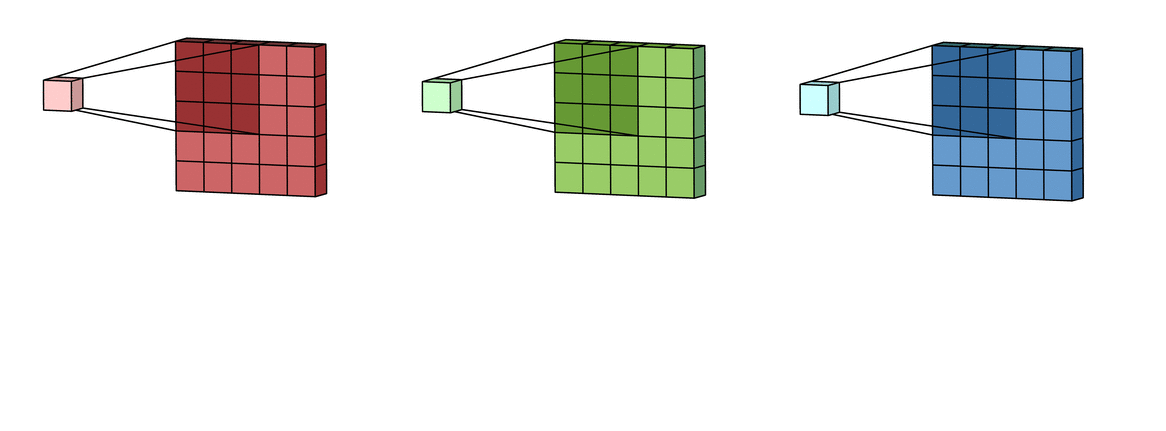 <br>
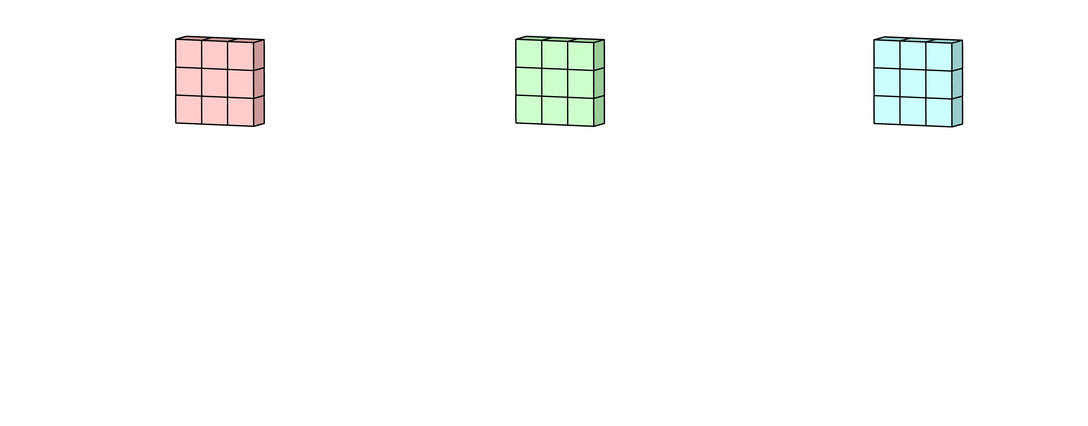 <br>
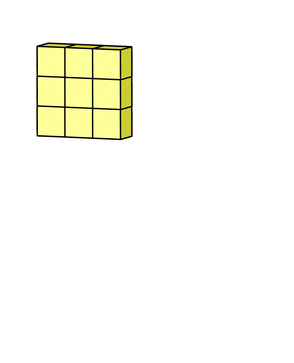 <br>

Nun so kriegt man also eine Feature-Map als Output. Was aber wenn man mehr Feature-Maps als Output haben will, also mehr Output-Channels. Dazu nimmt man sich einen neuen Kernel/Filter mit neuem Bias und macht den oben beschriebenen Ablauf nochmal. Eine Konvolutions-Schicht hat also genauso viele Kernel/Filter und Bias (plural) wie es output-channels gibt. Demanch gibt es natürlich auch genauso viele Feature-Maps, wie es output-channels gibt. <br>

Dies reicht eigentlich zur Erklärung der Konvolutions-Schicht, jedoch gibt es noch ein paar Tricks, denen sich bei der Bildverarbeitung durch Konvolutionen beholfen wird:

**Padding** <br>
Betrachtet man die Animationen oben, so fällt auf, dass die Pixel am Rande des Inputs nie mit der Mitte des Kernels/Filters multipliziert werden. So wird der Output der Konvolution auch immer dimensionsweise kleiner sein, als der Input. Um beide diese Nachteile zu umgehen wird der Input am Rand vergrößert indem Nullen hinzugefügt werden. Dies wird zero-Padding genannt, generell aber auch einfach Padding.<br>
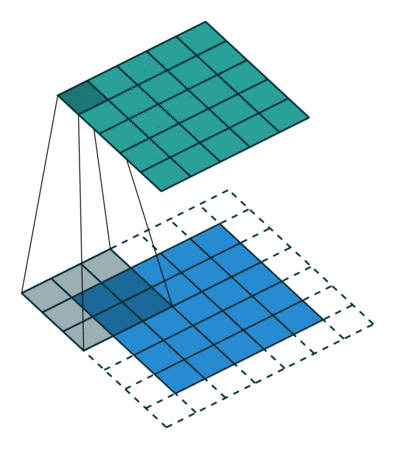 <br>


**Stride**<br>
Möchte man einen bestimmt kleineren Output als Input haben, möchte aber nicht, dass der Kernel/Filter zu groß wird, so kann man statt wie bei den Animationen oben gezeigt nicht nur ein Pixel nach rechts bzw. unten gehen, sonder gleich 2 oder mehr die Anzahl der Pixel die man nach rechts bzw. unten "springt" wird Stride genannt. <br>
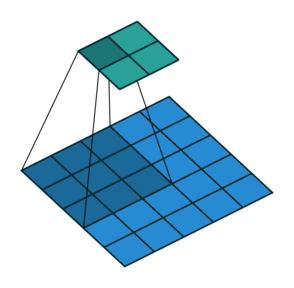 <br>

Dies sind nicht alle Parameter, welche bei der Konvolutions-Schicht zu berücksichtigen sind, es sind jedoch die wichtigsten. Weitere Parameter wären Dillation und Groups.

Trotz des unterschiedlichen Aufbaus von Konvolutionen sind diese genauso wie Fully-Connected Layer linear und brauchen somit auch nicht-lineare Aktivierungsfunktionen.

PyTorch-Implementierung
```Python
x = torch.randn(100, 3, 32, 32)
# Implementierung als Modul
conv = nn.Conv2d(
    in_channels=3,
    out_channels=6,
    kernel_size=3,#=(3,3)
    stride=1,
    padding=0,
)
y = conv(x)
print(y.shape)
```

### Normen
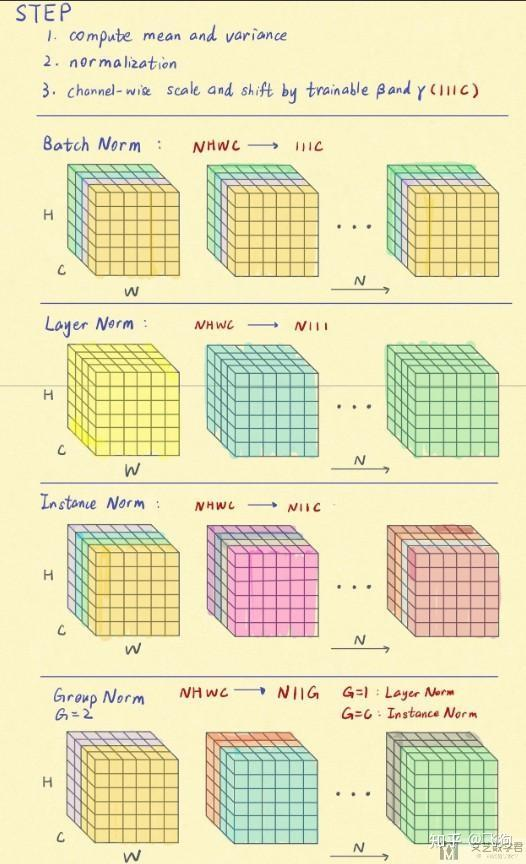

#### Batch Normalization
Die Daten vor dem Trainieren zu normalisieren bietet sich an, da sie so ähnlicher sind zumindestens mit ihren Werten. Das Modell muss sich also nicht immer wieder von neuen an unterschiedliche Skalen gewöhnen/anpassen. Dies macht den Trainingsprozess stabiler und lernt das Modell schneller. <br>
Nun, wenn sich das normalisieren der Daten vor dem Training anbietet, warum sollte man die Daten innerhalb des Modells nicht auch normalisieren? Die Batch-Norm macht genau das mit jeder Batch. Jeder Channel in der Batch wird mit ihrem Durchschnitt und Standardabweichung normalisiert und dann mit zwei lernbaren Parameter $\gamma$ und $\beta$ neu skaliert. 

Stellen wir uns das mit unseren Farbbild als Input vor: <br>
(100, 3, 32, 32) mit Dimenesionen (batch_size, channel, height, width)<br>
so werden von diesen 100 Inputs einmal die Rot-Bilder (channel 0) genommen und für all diese Durchschnitt, Standardabweichung gebildet, normalisiert und neu skaliert mit einem eigenen $\gamma$ und $\beta$. Das gleiche passiert jeweils mit eigenem $\gamma$ und $\beta$ für die Grün-Bilder (channel 1) und Blau-Bilder (channel 2). <br>
Es wird also nicht über die gesamte Batch normalisiert!!!

PyTorch-Implementierung
```Python
# random input mit dimensionen batch_size, channels, h, w
x = torch.randn(100, 3, 32, 32)
# Implementierung als Modul
batchNorm = nn.BatchNorm2d(
    # takes as input_size the channel_size
    num_features=3,
    # Wenn wahr (standard), dann wird mit lernbaren Parametern gamma und beta trainiert
    affine=True
)
y = batchNorm(x)
```

#### Layer Normalization
Ein Problem, welches bei der Batch Normalization auftreten könnte ist, dass wenn wir nur kleine Batches verarbeiten können und sich in der Batch ein Outlier befindet, so würde dieser die Daten der anderen Inputs in der Batch stark verzerren. Was mit dem Beispiel ausgedrückt werden soll, ist, dass je weniger Inputs es pro Batch gibt, desto stärker können Durchschnitt und Standardabweichung der Batch von dem Durchschnitt und der Standardabweichung des Datensatzes abweichen. <br>
Um dieses Problem bei kleinen Batches zu umgehen, beschränkt man sich hier nicht auf die ganze Batch sondern jeden Input. Es wird also nicht mehr über die Batch normalisiert, sondern über alle channel eines jeden Inputs.

Für unser Beispiel: <br>
(100, 3, 32, 32) mit Dimenesionen (batch_size, channel, height, width)<br>
Werden also die 100 Bilder/Inputs jeweils mit ihren eigenen Durchschnitt, Standardabweichung, $\gamma$ und $\beta$ normalisiert und neu skaliert. 

PyTorch-Implementierung
```Python
# random input mit dimensionen batch_size, channels, h, w
x = torch.randn(100, 3, 32, 32)
# Implementierung als Modul
layerNorm = nn.LayerNorm(
    # takes as input_size the channel_size, height and width
    normalized_shape=[3, 32, 32]
)
y = layerNorm(x)
```

#### Group Normalization
Für die Beispiele haben wir mögliche Dimensionen für den Input genommen, da man sich das besser vorstellen kann. Wir wollen diese Normalisierungsschichten eigentlich jedoch im Modell verwenden. Das heißt wir arbeiten eher mit solchen Dimensionen (100, 32, 8, 8). Höhe und Breite eines Channels nehmen also ab, die Anzahl an Channels jedoch zu. Dies liegt an der Lokalität der Konvolutionen. Da die Layer Norm über alle channels hinweg normalisiert, macht sie dies in einem extrem globalen Sinn. Wir wollen aber unsere Lokalität bewahren. Deswegen normalisieren wir bei der Group Norm nicht über alle Channel, sondern teilen diese in Gruppen ein und normalisieren über jede Gruppe einzeln.

```Python
# random input mit dimensionen batch_size, channels, h, w
x = torch.randn(100, 32, 8, 8)
# Implementierung als Modul
groupNorm = nn.GroupNorm(
    # takes as input_size the number of groups you want to split the channels into
    num_groups=8,
    # here for example 8 groups with 4 channels each
    # and the channel_size
    num_channels=32,
    # Wenn wahr (standard), dann wird mit lernbaren Parametern gamma und beta trainiert
    affine=True
)
# man kann die Layer Norm auch als Group Norm implementieren, so gibt es eine Gruppe, welche über die gesamte Anzahl an channeln normalisiert
layerNorm = nn.GroupNorm(
    num_groups=1,
    num_channels=32,
)
# oder auch als die nächste Norm, die Instance Norm, so gibt es 32 Gruppen mit jeweils einem channel
instanceNorm = nn.GroupNorm(
    num_groups=32,
    num_channels=32,
)
y = groupNorm(x)
```

#### Instance Normalization
Die Instance Norm wie oben schon gezeigt geht noch einen Schritt weiter und Normalisiert pro batch pro channel.

PyTorch-Implementierung
```Python
# random input mit dimensionen batch_size, channels, h, w
x = torch.randn(100, 32, 8, 8)
# Implementierung als Modul
instanceNorm = nn.InstanceNorm2d(
    # takes as input_size the channel_size
    num_features=32,
    # Wenn wahr (standard), dann wird mit lernbaren Parametern gamma und beta trainiert
    affine=True
)
y = instanceNorm(x)
```

#### Pooling
Das Arbeiten mit Bildern ist rechenintensiv. Um die Dimension der Bilder schnell zu verkleinern, kann man neben gut gewählten Parmetern für Konvolutions auch Pooling-Schichten verwenden. Diese Schichten funktionieren sehr ähnlich zu Konvolutionen, dass sie auch Kernel hat, welcher über den Input fährt und somit gibt es auch Parameter für Padding und Stride. Der große Unterschied zu Konvolutionen ist, dass diese Schicht keine lernbaren Parameter hat, da hier der Kernel nicht ein Matrix ist, mit der multipliziert wird, sondern der Kernel entscheidet hier nur, welcher Ausschnitt des Inputs gerade ausgewählt wird. Demanch gibt es auch keinen Bias. Anstatt der Matrix-Multiplikation gibt es hier jedoch eine Funktion, welche auf den ausgewählten Teil des Inputs angewendet wird. 

Bei der Max-Pooling Schicht ist wie der Name schon sagt diese Funktion max(x), es wird also der größte Wert des ausgewählten Bereiches ausgewählt und übernommmen.

Bei der Average-Pooling Schicht wird der Durchschnitt des ausgewählten Bereiches genommen.

Anders als bei Konvolutions-Schichten läuft der Kernel über jeden Channel separat. Diese Outputs werden also nicht summiert. Somit sind die in_channels auch gleich der out_channels (bei der Addition würden die out_channels sonst ja 1 sein).

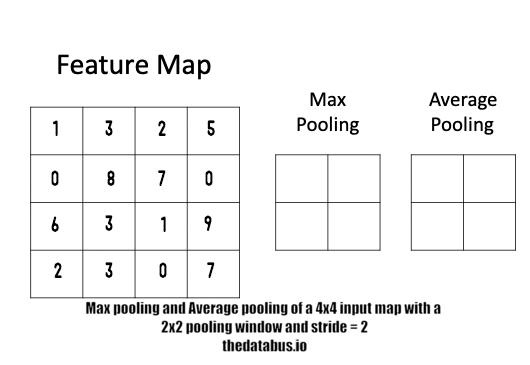

PyTorch-Implementierung
```Python
# input
x = torch.randn(100, 3, 32, 32)
# Implementierung als Modul
maxPool = nn.MaxPool2d(
    kernel_size=3,#=(3,3)
    stride=1,
    padding=0,
)
avgPool = nn.AvgPool2d(
    kernel_size=3,#=(3,3)
    stride=1,
    padding=0,
)
y_max = maxPool(x)
y_avg = avgPool(x)
print(y_max.shape,  y_avg_.shape)
```

Beim Pooling ist im Vergleich zu Konvolutions der Stride meistens größer, wie im animierten Beispiel gezeigt. 

Es gibt noch viele weitere Pooling Schichten.

#### Dropout
Die Dropout Schicht schaltet pro Iteration zufällig gewählte Neuronen einer gewählten Schicht aus bzw. setzt ihre Ausgaben auf 0.
Dadurch wird das Modell robuster, da es sich so schlecht auf sehr spezifische, unwichtige Details konzentrieren kann, sich also nicht Überanpassen kann an den Trainingsdatensatz. Die Dropout Schicht wird nur während des Trainings benutzt und ist während der Validierung und des Tests aus. 

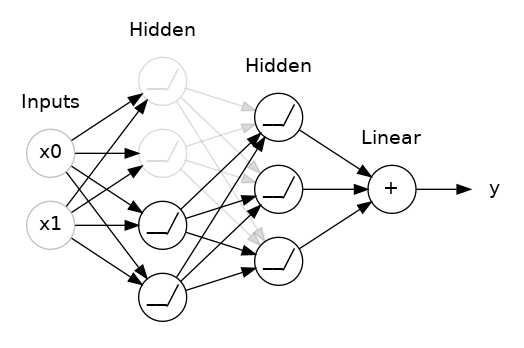 <br>

Hier ein Beispiel mit einem Dropout von 50%.

PyTorch-Implementierung
```Python
x = torch.randn(20, 32, 8, 8)
# Implementierung als Modul
dropout = nn.Dropout(
    # Wahrscheinlichkeit, dass ein Neuron ausgeschaltet ist.
    p=0.5,
)
y = dropout(x)
# Implementierung als Funktion
y = F.dropout(
    input=x, 
    p=0.5,
    # anders als beim Modul, welches vererbt bekommt ob das Modell gerade trainiert, muss dies hier selbst gestellt werden
    training=True,
)
print(y)
```

In [ ]:
class MyModel(nn.Module):
    def __init__(self, num_classes):
        super(MyModel, self).__init__()
        #Initalisiere deine Module
        pass

    def forward(self, x):
        #gebe den Input an deine vorher Initalisierten Module
        return x
        

In [77]:
class TinyCNN(nn.Module):
    def __init__(self, num_classes=10):
        super(TinyCNN, self).__init__()
        
        # Convolutional layers
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=8, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(in_channels=8, out_channels=16, kernel_size=3, padding=1)
        
        # Pooling layer
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)  # Halves spatial dimensions
        
        # Fully connected layers
        self.fc1 = nn.Linear(1024, 32)  # 16x16x16 -> 3216 * 16 * 16
        self.fc2 = nn.Linear(32, num_classes)  # 32 -> num_classes
    
    def forward(self, x):
        # Convolutional layers with ReLU and pooling
        x = self.pool(F.relu(self.conv1(x)))  # 8x64x64 -> 8x32x32
        x = self.pool(F.relu(self.conv2(x)))  # 16x32x32 -> 16x16x16
        
        # Flatten the feature maps
        x = x.view(x.size(0), -1)  # Dynamically calculate the flattened size
        #print(x.shape)
        # Fully connected layers
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x

class SmallCNN(nn.Module):
    def __init__(self, num_classes=10):
        super(SmallCNN, self).__init__()
        
        # Convolutional layers
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=16, kernel_size=3, padding=1)  # 3x64x64 -> 16x64x64
        self.conv2 = nn.Conv2d(in_channels=16, out_channels=32, kernel_size=3, padding=1)  # 16x32x32 -> 32x32x32
        self.conv3 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, padding=1)  # 32x16x16 -> 64x16x16
        
        # Pooling layer
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)  # Halves spatial dimensions
        
        # Fully connected layers
        self.fc1 = nn.Linear(64 * 8 * 8, 128)  # 64x8x8 -> 128
        self.fc2 = nn.Linear(128, num_classes)  # 128 -> num_classes
    
    def forward(self, x):
        # Convolutional layers with ReLU and pooling
        x = self.pool(F.relu(self.conv1(x)))  # 16x64x64 -> 16x32x32
        x = self.pool(F.relu(self.conv2(x)))  # 32x32x32 -> 32x16x16
        x = self.pool(F.relu(self.conv3(x)))  # 64x16x16 -> 64x8x8
        
        # Flatten the feature maps
        x = x.view(x.size(0), -1)  # Dynamically calculate the flattened size
        
        # Fully connected layers
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x

##### Criterion
- L1Loss
- MSEloss
- BCELoss

##### Optimizers
- SGD
- Adam
- AdamW
- RMSprop
- Adagrad

### Training

In [74]:
model = TinyDense(num_classes=2).to(device)
#model = SmallCNN(num_classes=2).to(device)
#model = models.resnet18(pretrained=False)
#model.fc = nn.Linear(model.fc.in_features, 2)
#model = model.to(device)
reduction = "mean"
criterion = nn.CrossEntropyLoss(reduction=reduction)
optimizer = optim.Adam(model.parameters(), lr=0.001)

#visualize the model
model

TinyDense(
  (fc1): Linear(in_features=3072, out_features=1000, bias=True)
  (fc2): Linear(in_features=1000, out_features=500, bias=True)
  (fc3): Linear(in_features=500, out_features=2, bias=True)
)

In [75]:
epochs = 15
losses = []
train_accs = []
val_accs = []
for i in range(epochs):
    print(f"Epoch: {i+1}")

    #training
    model.train()
    epoch_loss = 0
    epoch_acc = 0
    for inputs, labels in tqdm(trainloader):
        #load to gpu if possible
        inputs = inputs.to(device)
        labels = labels.to(device)
        #forward pass
        outputs = model(inputs)
        #calculate loss
        loss = criterion(outputs, labels.argmax(dim=-1))
        #backward propagation
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        #logging
        epoch_loss += loss.item()
        epoch_acc += (outputs.argmax(dim=-1) == labels.argmax(dim=-1)).sum().item()/len(labels)
    #logging
    epoch_loss = epoch_loss/len(trainloader)
    epoch_acc = epoch_acc/len(trainloader)
    losses.append(epoch_loss)
    train_accs.append(epoch_acc)
    
    #validation
    with torch.no_grad():
        epoch_loss = 0
        epoch_acc = 0
        for inputs, labels in tqdm(valloader):
            #load to gpu if possible
            inputs = inputs.to(device)
            labels = labels.to(device)
            #forward pass
            outputs = model(inputs)
    
            #logging
            epoch_acc += (outputs.argmax(dim=-1) == labels.argmax(dim=-1)).sum().item()/len(labels)
        #logging
        epoch_acc = epoch_acc/len(valloader)
        val_accs.append(epoch_acc)

#testing
with torch.no_grad():
    epoch_loss = 0
    epoch_acc = 0
    for inputs, labels in tqdm(testloader):
        #load to gpu if possible
        inputs = inputs.to(device)
        labels = labels.to(device)
        #forward pass
        outputs = model(inputs)

        #logging
        epoch_acc += (outputs.argmax(dim=-1) == labels.argmax(dim=-1)).sum().item()/len(labels)
    #logging
    epoch_acc = epoch_acc/len(testloader)
    test_acc = epoch_acc

Epoch: 1


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:01<00:00, 43.65it/s]


Epoch: 2


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:01<00:00, 44.94it/s]


Epoch: 3


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:01<00:00, 42.57it/s]


Epoch: 4


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:01<00:00, 44.42it/s]


Epoch: 5


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:01<00:00, 44.69it/s]


Epoch: 6


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:01<00:00, 45.08it/s]


Epoch: 7


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:01<00:00, 42.52it/s]


Epoch: 8


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:01<00:00, 42.88it/s]


Epoch: 9


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:01<00:00, 43.81it/s]


Epoch: 10


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:01<00:00, 44.97it/s]


Epoch: 11


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:01<00:00, 44.58it/s]


Epoch: 12


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:01<00:00, 45.26it/s]


Epoch: 13


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:01<00:00, 44.19it/s]


Epoch: 14


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:01<00:00, 43.80it/s]


Epoch: 15


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 26/26 [00:00<00:00, 34.35it/s]


### Evaluation

#### Plotting the Results

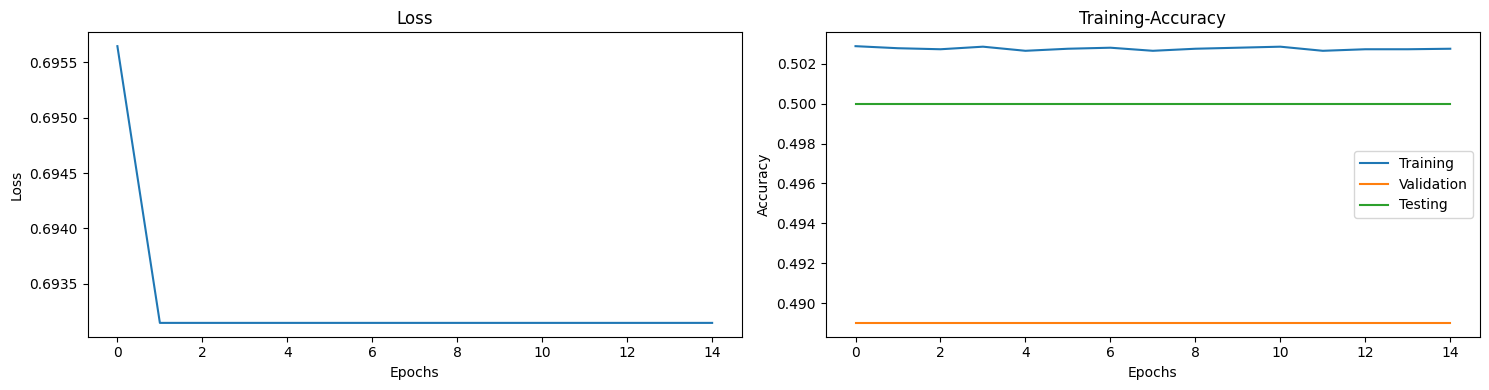

In [76]:
fig, axes = plt.subplots(1, 2, figsize=(15, 4))
axes[0].set_title("Loss")
axes[0].plot(losses, label="loss")
axes[0].set_xlabel("Epochs")
axes[0].set_ylabel("Loss")
axes[1].set_title("Training-Accuracy")
axes[1].plot(train_accs, label="Training")
axes[1].plot(val_accs, label="Validation")
axes[1].plot([test_acc]*epochs, label="Testing")
axes[1].set_xlabel("Epochs")
axes[1].set_ylabel("Accuracy")
axes[1].legend()
plt.tight_layout()
plt.show()

#### Looking at some Examples

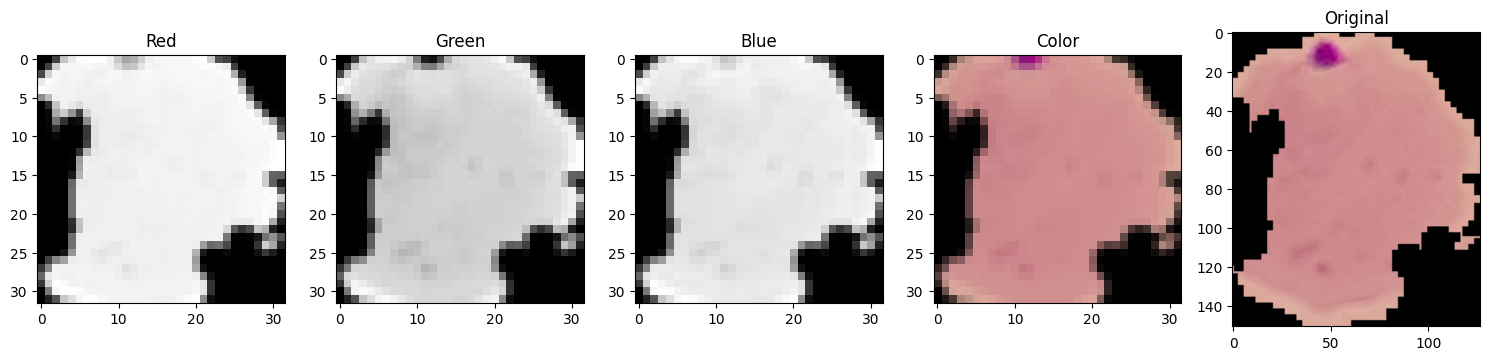

Predicted Class: parasitized
Modell Certainty: 0.96
Actual Class: parasitized


In [49]:
i=19
batch = next(iter(testloader))
batch_output = model(batch[0].to(device))
image = batch[0][i]
label = batch[1][i]

fig, axes = plt.subplots(1, 5, figsize=(15, 6))
axes[0].set_title("Red")
axes[0].imshow(image[0, :, :], cmap="gray")
axes[1].set_title("Green")
axes[1].imshow(image[1, :, :], cmap="gray")
axes[2].set_title("Blue")
axes[2].imshow(image[2, :, :], cmap="gray")
axes[3].set_title("Color")
axes[3].imshow(image.transpose(0, 1).transpose(1, 2), cmap="gray")
axes[4].set_title("Original")
axes[4].imshow(Image.open(testset.samples[i][0]))
plt.tight_layout()
plt.show()
print(f"Predicted Class: {label_decoding(batch_output[i].argmax(dim=-1).detach())}")
print(f"Modell Certainty: {round(F.softmax(batch_output[i], dim=-1)[batch_output[i].argmax(dim=-1).item()].item(), 2)}")
print(f"Actual Class: {label_decoding(label)}")

#### Classification Report

In [50]:
from sklearn.metrics import confusion_matrix
import seaborn as sn
import pandas as pd

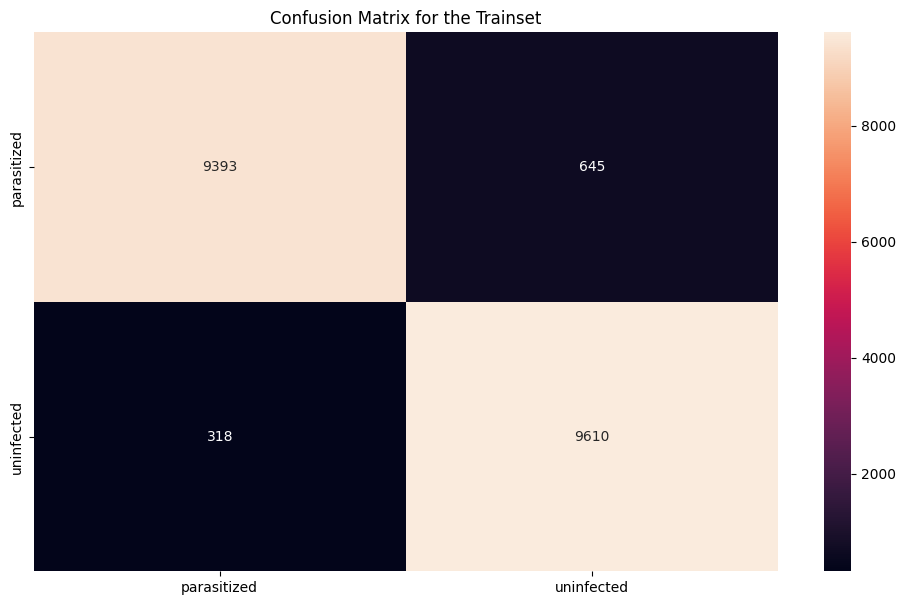

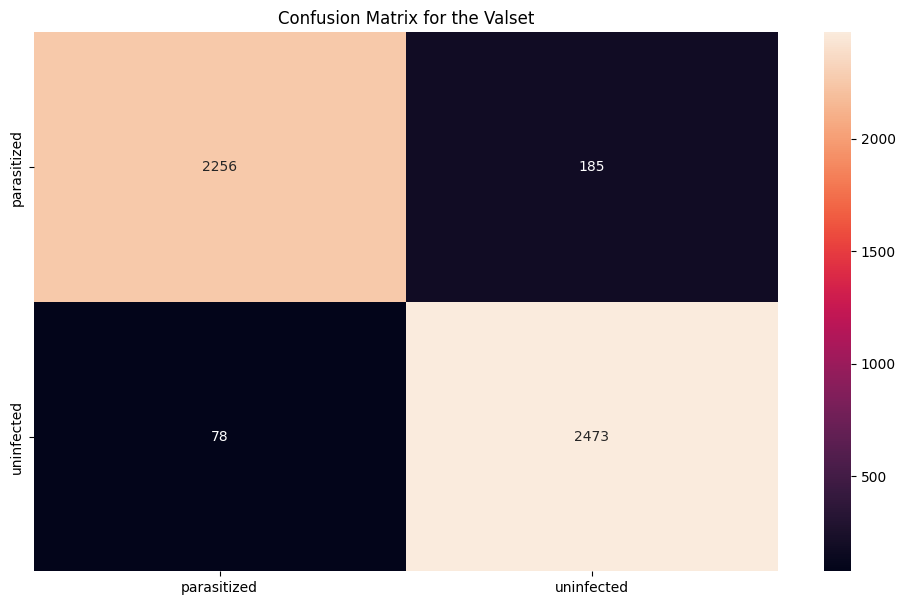

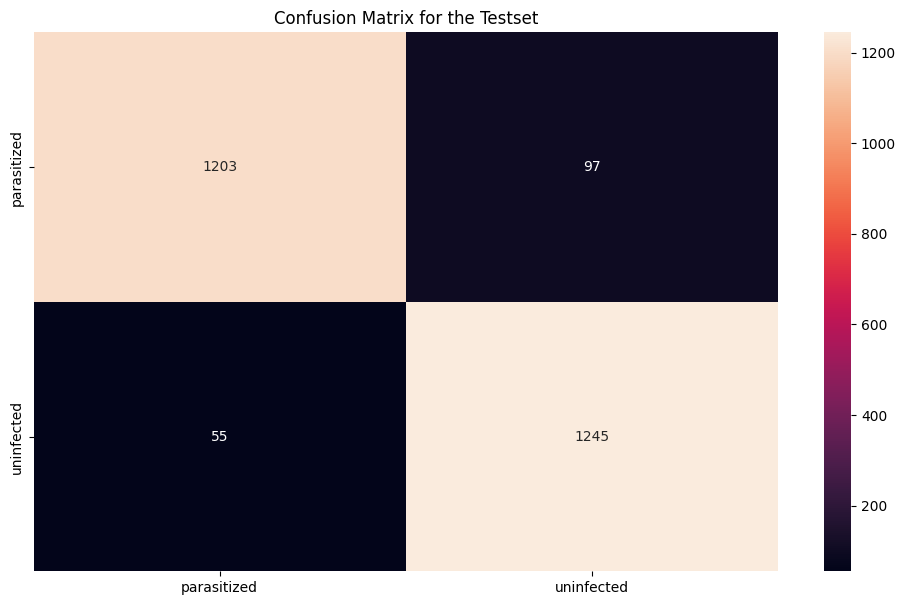

In [51]:
def get_classification_report(model, loader, classes, name):
    with torch.no_grad():
        y_pred, y_true = [], []
        for inputs, labels in loader:
            #load to gpu if possible
            inputs = inputs.to(device)
            #forward pass
            outputs = model(inputs)
            outputs = outputs.argmax(dim=-1)
            y_pred.extend(outputs.detach().cpu().numpy())
            
            labels = labels.argmax(dim=-1)
            y_true.extend(labels)
    
        cf_matrix = confusion_matrix(y_true, y_pred)
        #in percentile
        #df_cm = pd.DataFrame((cf_matrix/np.sum(cf_matrix)), index = [i for i in classes], columns = [i for i in classes])
        #not
        df_cm = pd.DataFrame(cf_matrix, index = [i for i in classes], columns = [i for i in classes])
        plt.figure(figsize = (12,7))
        plt.title("Confusion Matrix for the " + name)
        sn.heatmap(df_cm, fmt=".0f", annot=True)

classes = list(CLASS_IDX.keys())
get_classification_report(model, trainloader, classes, "Trainset")
get_classification_report(model, valloader, classes, "Valset")
get_classification_report(model, testloader, classes, "Testset")

### Looking in the Model / Explainability

#### Looking at the Convolutions

Total convolution layers: 2
conv_layers


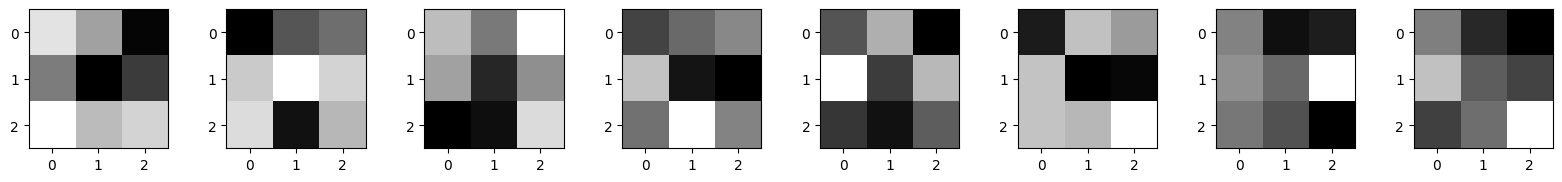

In [132]:
model_weights =[]
conv_layers = []
children = list(model.children())

counter = 0
#append the conv-layers from the convNet
for i in range(len(children)):
    if type(children[i]) == torch.nn.modules.conv.Conv2d:
        counter += 1
        model_weights.append(children[i].weight)
        conv_layers.append(children[i])

print(f"Total convolution layers: {counter}")
print("conv_layers")

plt.figure(figsize=(20, 17))
for i, filter in enumerate(model_weights[0]):
    plt.subplot(8, 8, i+1)
    plt.imshow(filter[0, :, :].cpu().detach().numpy(), cmap='gray')
plt.show()

Layer:  1
Layer-Dimensions:  torch.Size([8, 64, 64])


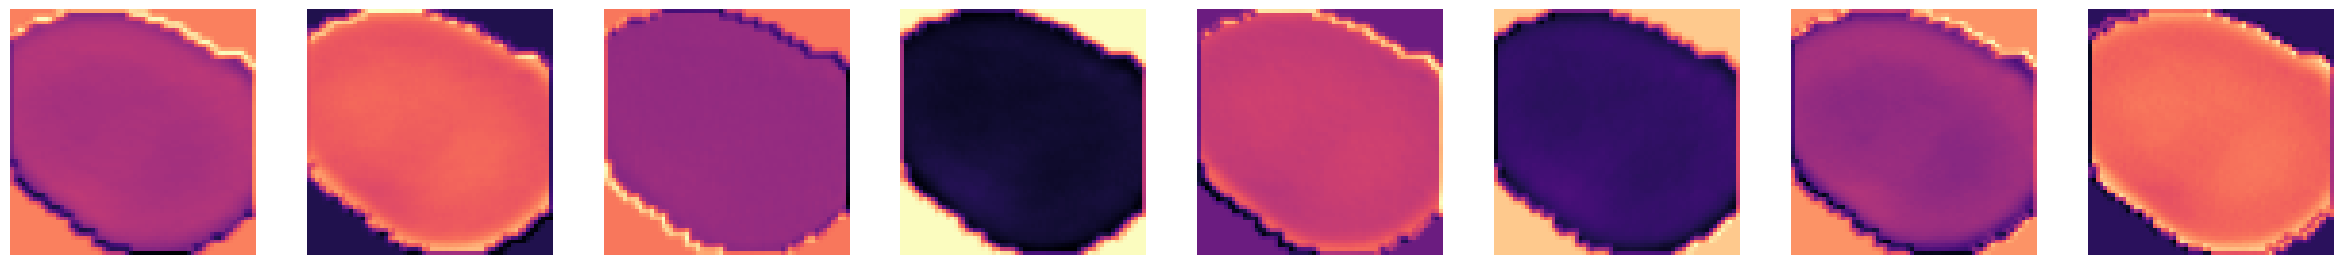

Layer:  2
Layer-Dimensions:  torch.Size([16, 32, 32])


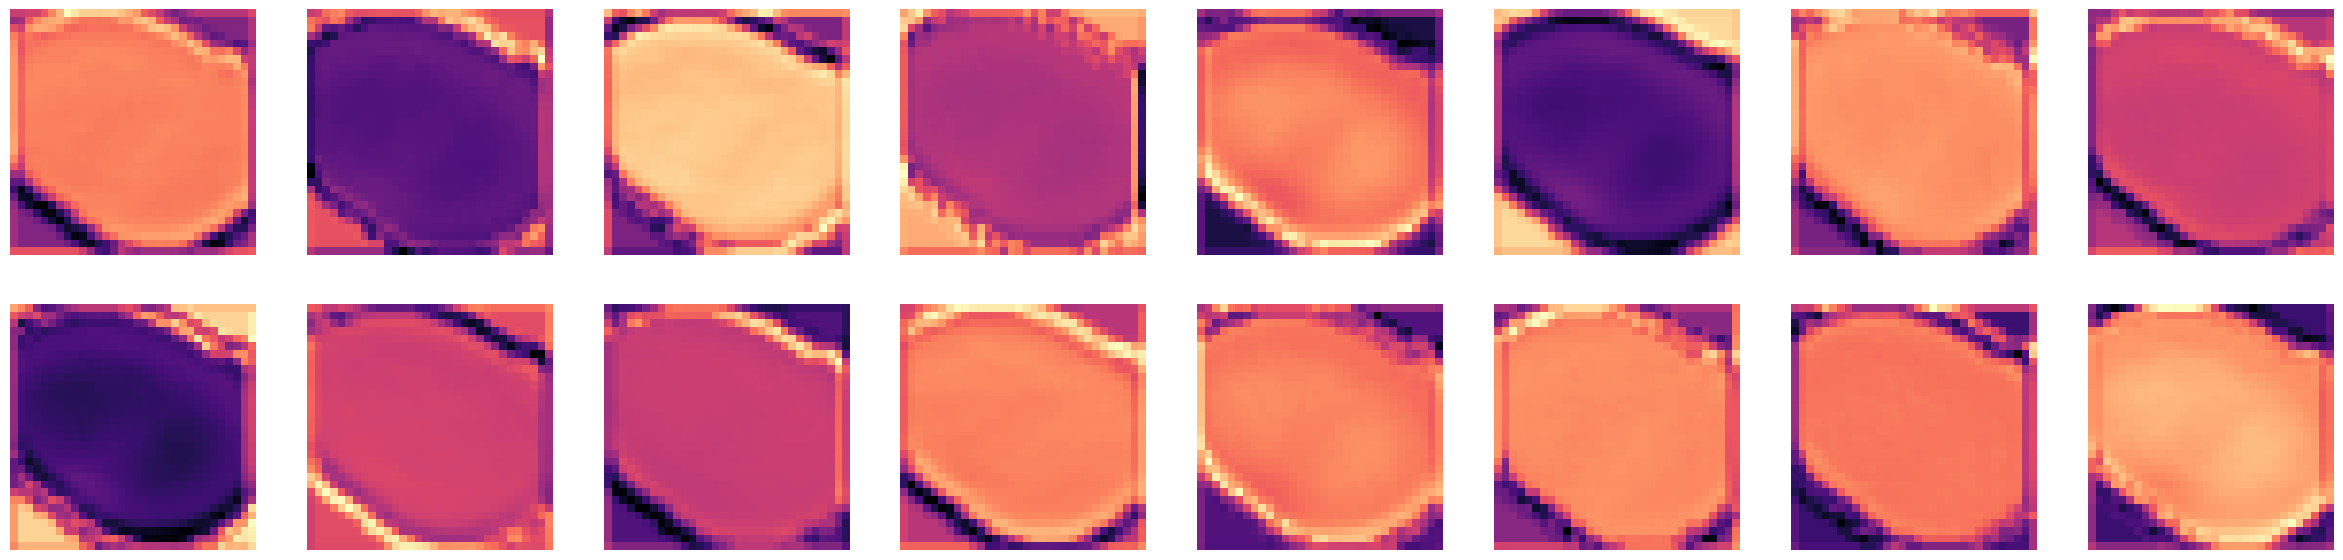

In [148]:
random_num = random.randint(0, batch_size-1)
batch = next(iter(trainloader))
inp_data, labels = batch
inp_data = inp_data[0].to(device)


results = [conv_layers[0](inp_data)]
for i in range(1, len(conv_layers)):
    results.append(conv_layers[i](F.max_pool2d(F.relu(results[-1]), kernel_size=2, stride=2)))
outputs = results

for num_layer in range(len(outputs)):
    plt.figure(figsize=(30, 30))
    layer_viz = outputs[num_layer]
    #print(outputs[num_layer].size())
    layer_viz = layer_viz.data
    print("Layer: ", num_layer+1)
    print("Layer-Dimensions: ",layer_viz.size())
    for i, filter in enumerate(layer_viz):
        if i == 64: # we will visualize only 8x8 blocks from each layer
            break
        plt.subplot(8, 8, i + 1)
        plt.imshow(filter.cpu().detach().numpy(), cmap='magma')
        plt.axis("off")
    plt.show()

#### Saliency Maps

predicted class;  uninfected
Modell Certainty: 0.99
actual class:  uninfected


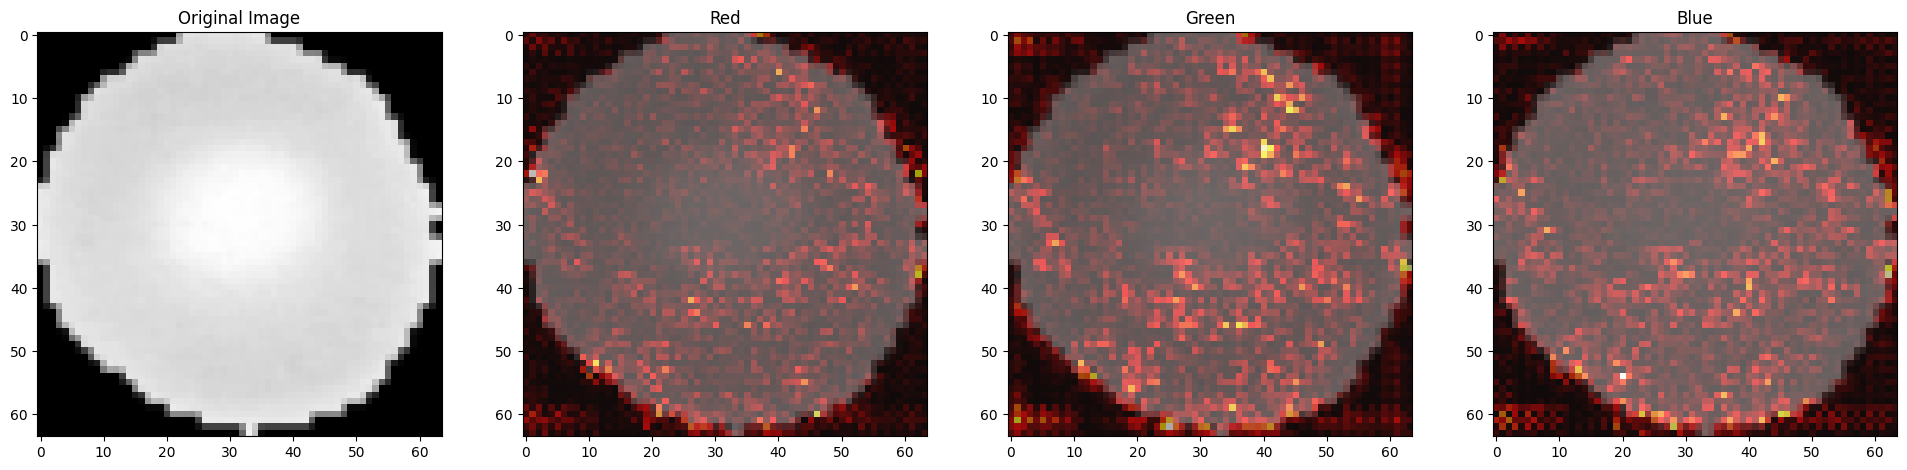

In [35]:
random_num = random.randint(0, batch_size-1)
test_batch = next(iter(trainloader))
inp_data, labels = test_batch
labels = labels.to(dtype=torch.float, device=device)
inp_data = inp_data.to(device).requires_grad_(True)

preds = model.forward(inp_data)
loss = criterion(preds, labels)
loss.backward()

specificGrad = inp_data.grad.data[random_num]
#calculate saliency
slc = specificGrad.abs()
#normalize to [0..1]
slc = (slc - slc.min()) / (slc.max()- slc.min())
slc_map = slc.cpu()

print("predicted class; ", classes[preds[random_num].argmax(dim=-1).item()])
print(f"Modell Certainty: {round(F.softmax(batch_output[i], dim=-1)[batch_output[i].argmax(dim=-1).item()].item(), 2)}")
print("actual class: ", classes[labels[random_num].argmax(dim=-1).item()])

#plot saliency
fig, ax = plt.subplots(1, 4, figsize=(5, 5))
#set plot size
fig.set_size_inches(24, 24)
#Plot normal image
plt.gray()
ax[0].title.set_text('Original Image')
ax[0].imshow(inp_data[random_num][0].cpu().detach().numpy(), interpolation="nearest")

ax[1].title.set_text('Red')
ax[1].imshow(inp_data[random_num][0].cpu().detach().numpy(), interpolation="nearest", alpha=0.9)
ax[1].imshow(slc_map[0], cmap='hot', alpha=.6)

ax[2].title.set_text('Green')
ax[2].imshow(inp_data[random_num][1].cpu().detach().numpy(), interpolation="nearest", alpha=0.9)
ax[2].imshow(slc_map[1], cmap='hot', alpha=.6)

ax[3].title.set_text('Blue')
ax[3].imshow(inp_data[random_num][2].cpu().detach().numpy(), interpolation="nearest", alpha=0.9)
ax[3].imshow(slc_map[2], cmap='hot', alpha=.6)

fig.show()

#### Grad-Cam

In [2]:
from pytorch_grad_cam import GradCAM
from pytorch_grad_cam.utils.model_targets import ClassifierOutputTarget
from pytorch_grad_cam.utils.image import show_cam_on_image
from pytorch_grad_cam.sobel_cam import sobel_cam

Actual Label:  parasitized
Modell Certainty: 0.9993
Predicted Label:  parasitized


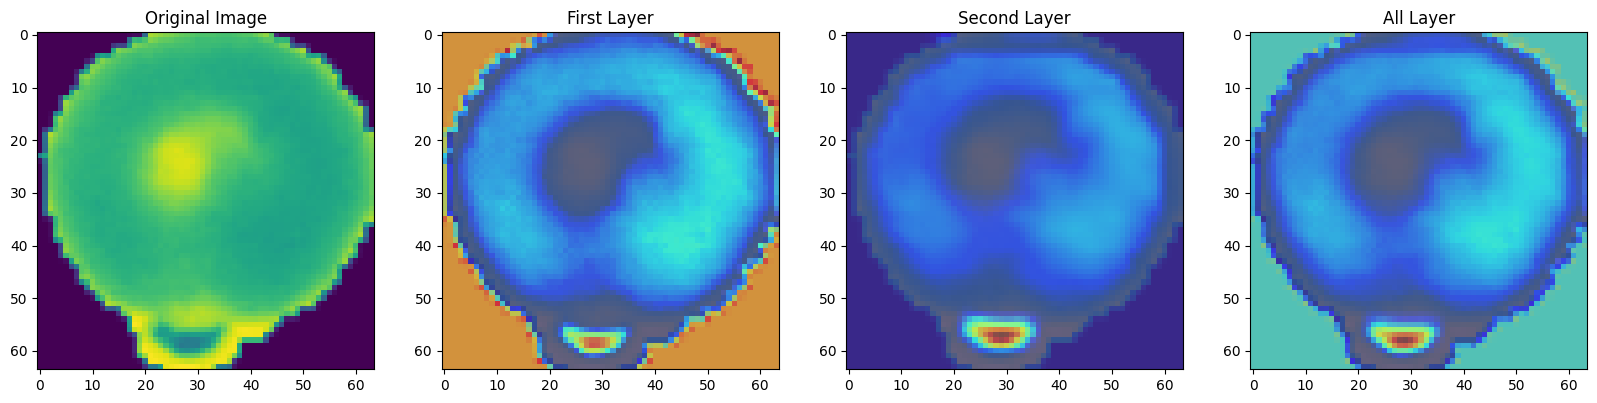

In [29]:
random_num = random.randint(0, batch_size-1)
def get_cam(model, x, target_layers):
    cam = GradCAM(model=model, target_layers=target_layers)
    
    grayscale_cam = cam(input_tensor=x)
    return grayscale_cam

batch = next(iter(testloader))
inp_data, labels = batch

inp_data = torch.Tensor(inp_data).to(torch.float).to(device)

target_layers = [model.conv1, model.conv2]

output = model(inp_data)
print("Actual Label: ", classes[labels[random_num].argmax()])
print(f"Modell Certainty: {round(F.softmax(output[i], dim=-1)[output[i].argmax(dim=-1).item()].item(), 4)}")
print("Predicted Label: ", classes[output[random_num].argmax()])

alpha_original = 0.6
alpha_maps = .6

fig, ax = plt.subplots(1, 4, figsize=(5, 5))

fig.set_size_inches(20, 20)

ax[0].title.set_text('Original Image')
ax[0].imshow(np.array(rgb2gray(inp_data[random_num].cpu())), interpolation="nearest")

ax[1].title.set_text('First Layer')
ax[1].imshow(np.array(rgb2gray(inp_data[random_num].cpu())), interpolation="nearest", alpha=alpha_original)
ax[1].imshow(get_cam(model, inp_data, target_layers=target_layers[:1])[random_num, :], alpha=alpha_maps, cmap="jet")

ax[2].title.set_text('Second Layer')
ax[2].imshow(np.array(rgb2gray(inp_data[random_num].cpu())), interpolation="nearest", alpha=alpha_original)
ax[2].imshow(get_cam(model, inp_data, target_layers=target_layers[1:2])[random_num, :], alpha=alpha_maps, cmap="jet")

ax[3].title.set_text('All Layer')
ax[3].imshow(np.array(rgb2gray(inp_data[random_num].cpu())), interpolation="nearest", alpha=alpha_original)
ax[3].imshow(get_cam(model, inp_data, target_layers=target_layers[:])[random_num, :], alpha=alpha_maps, cmap="jet")

plt.show()